In [42]:
## Library Import

# Basic
import re
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# AutoML optuna library
import optuna
import optuna.integration.lightgbm as lgb

# Linear Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Tree Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Metric
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## for PCA
from sklearn.decomposition import PCA

# for VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [48]:
fin_df = pd.read_csv('df_20200324_2.csv', index_col = 0)

In [49]:
X_data = fin_df.copy()

In [50]:
fin_df.reset_index(inplace = True)

In [51]:
date = X_data.date

In [52]:
target = X_data['KRXsemiconductor_close']

In [53]:
X_data.drop(['date', 'KRXsemiconductor_close'], axis = 1, inplace = True)

In [11]:
#X_data = X_data[['KODIBALIndex',
 'KOULMGFIndex120',
 'KOBONTLIndex',
 'Facebook_close120',
 'KOFDITYIndex',
 'Nuvoton_close260',
 'KOIMPTIMIndex',
 'KOCICONFIndex120',
 'KOEAUERSIndex',
 'KOCGCGYIndex',
 'KOVMEXPSIndex',
 'Microsoft_close120',
 'KOGCSTOQIndex',
 'KOECFCSYIndex',
 'KOCPIYOYIndex120',
 'KOHOINCYIndex120',
 'KOPPIMOMIndex',
 'CONSSENTIndex120',
 'Micron_close260',
 'KODFTOTYIndex',
 'USWHTOTIndex120',
 'LEICHNGIndex',
 'DGNOYOYIndex',
 'KOMSM2YIndex120',
 'SKBSICSAIndex120',
 'SKLICONEIndex',
 'SKLILAIIndex120',
 'FDTRIndex260',
 'GDPCURYIndex']]

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

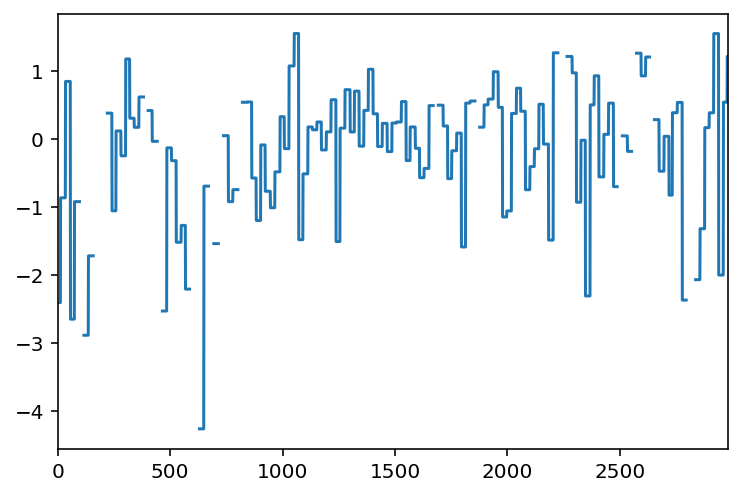

In [40]:
np.log1p(X_data['KODIBALIndex']).plot()

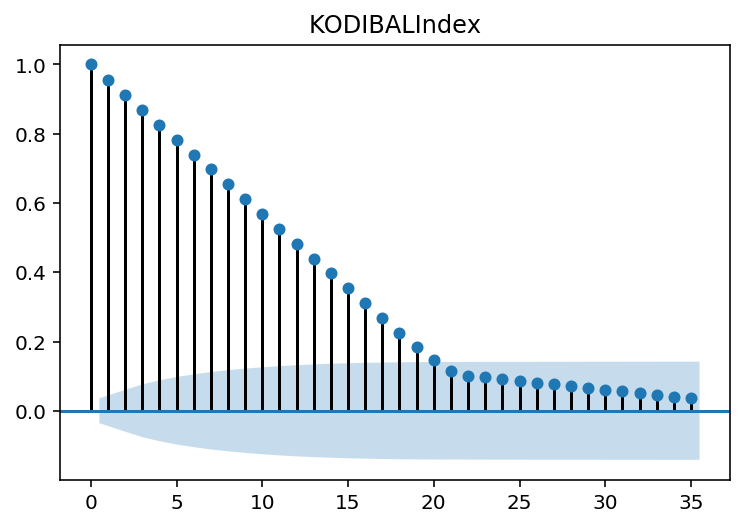

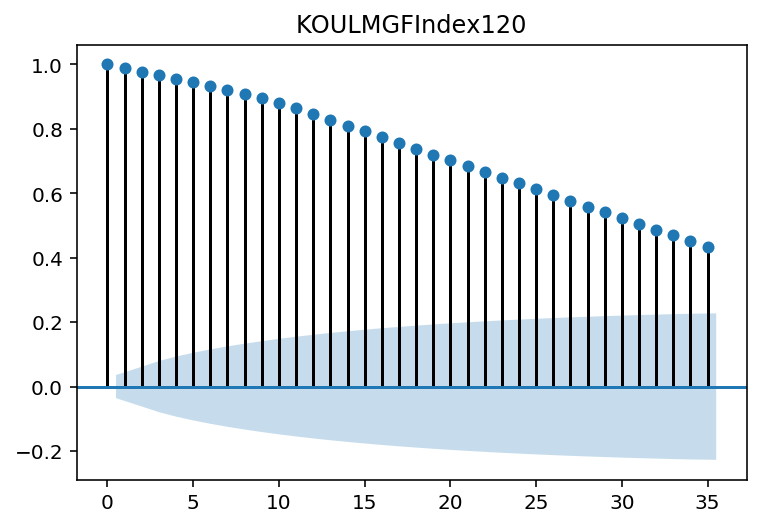

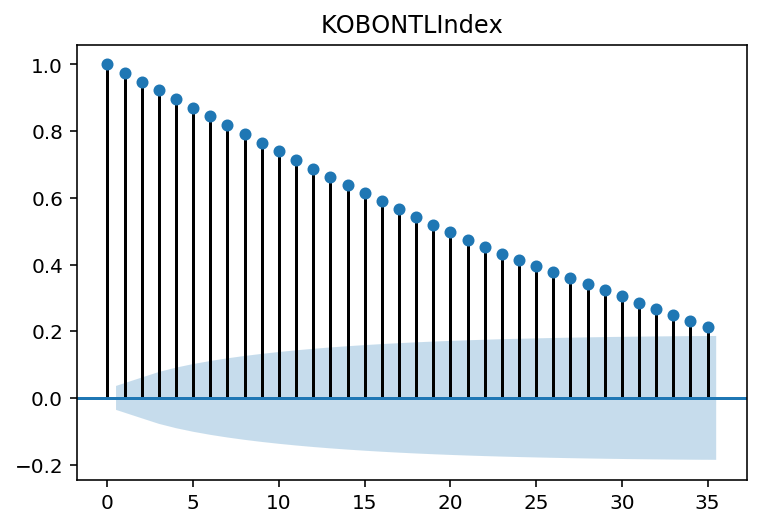

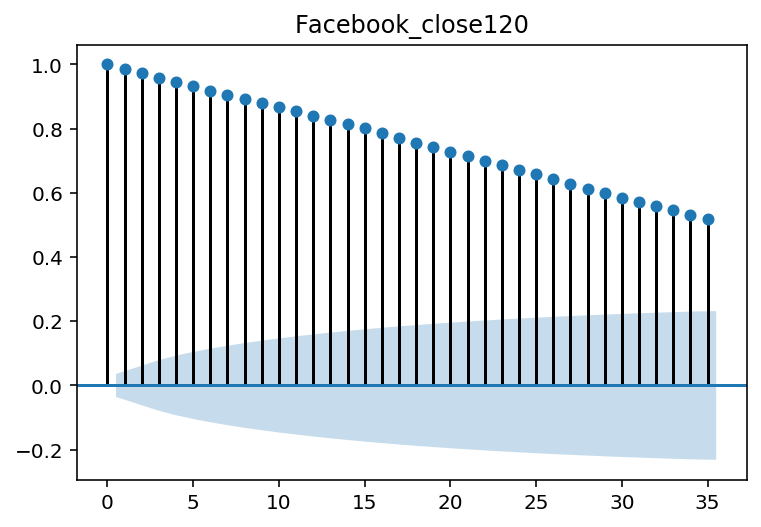

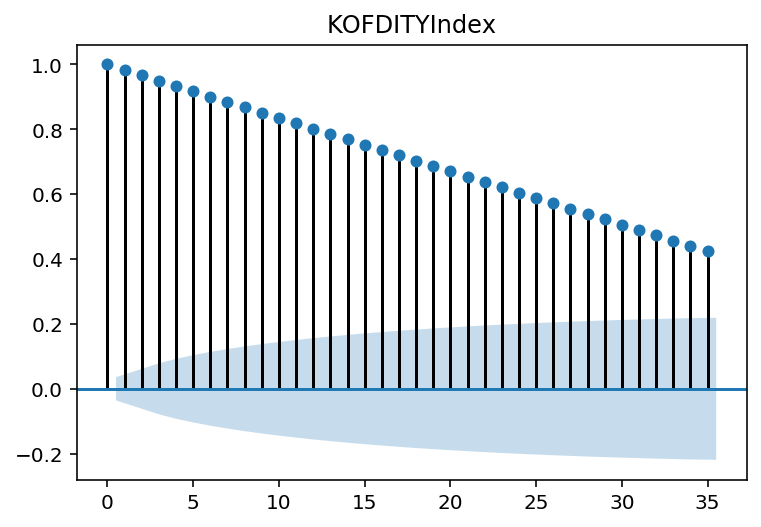

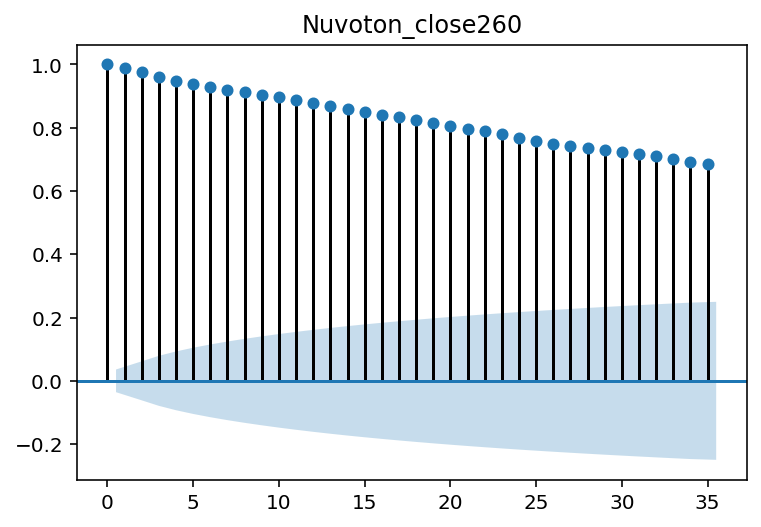

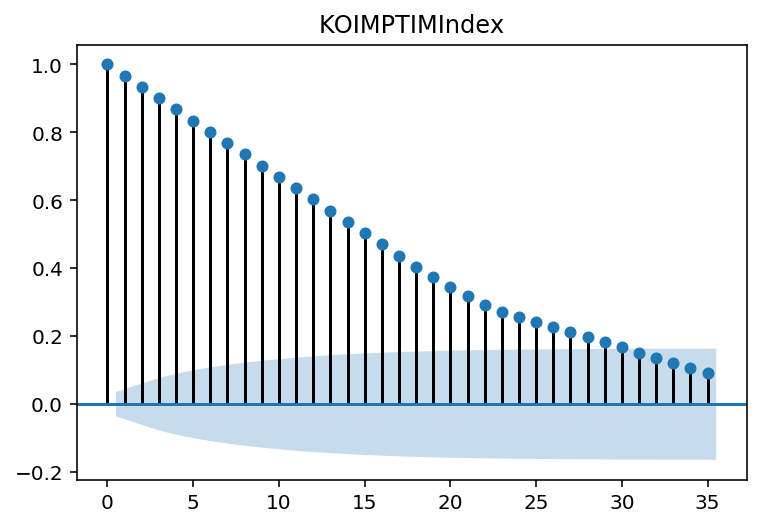

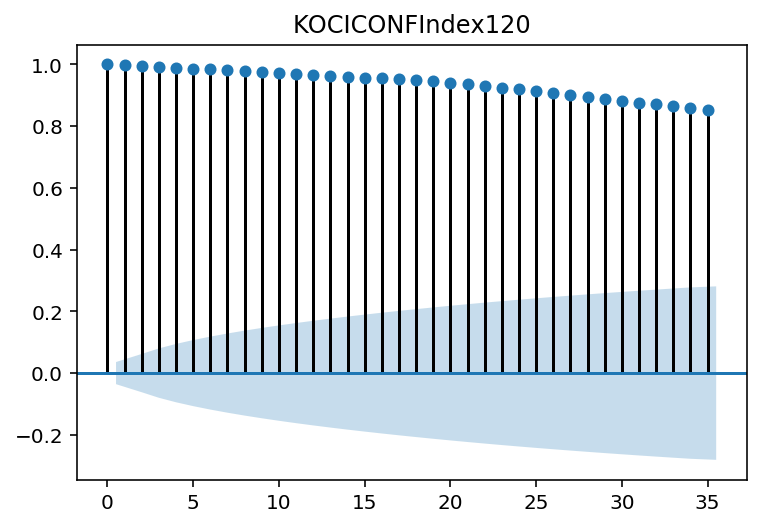

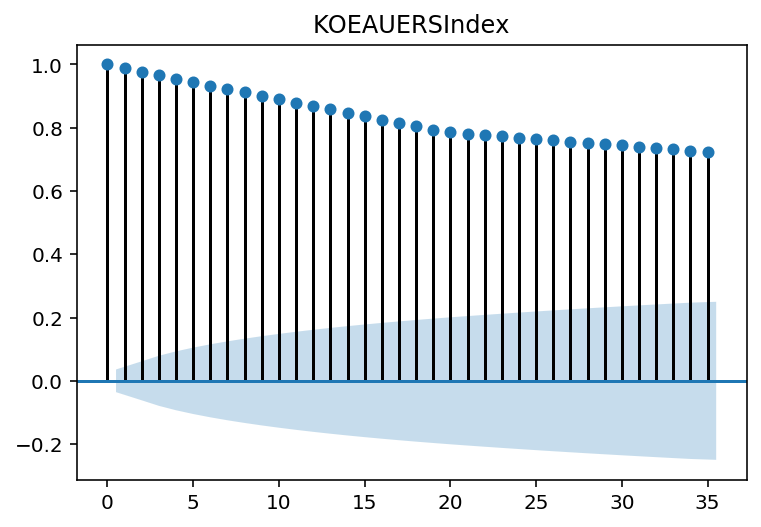

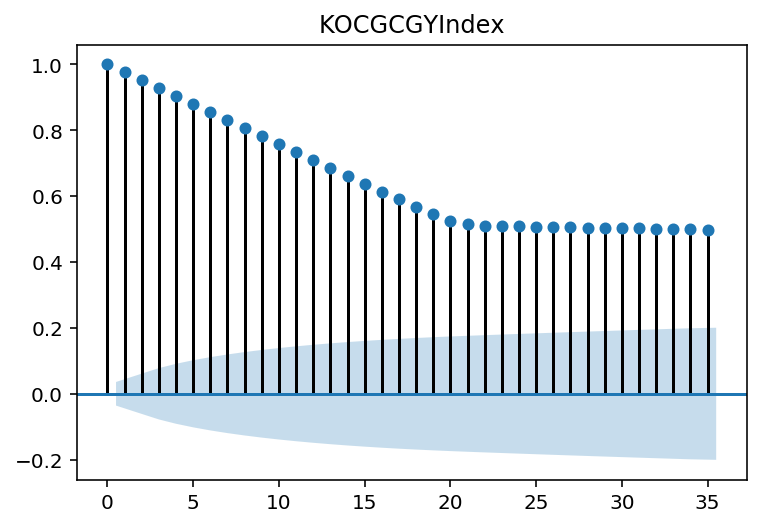

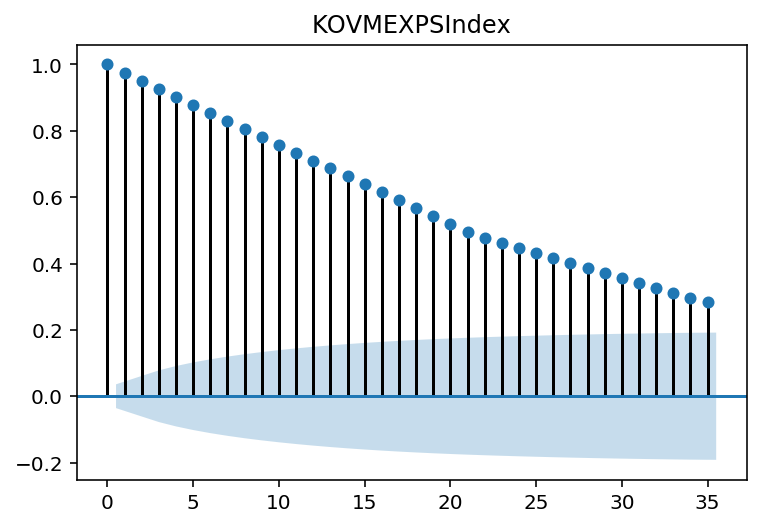

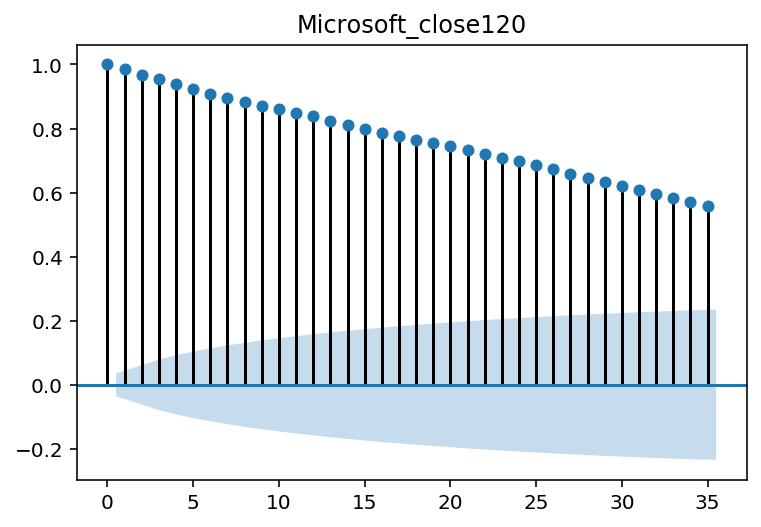

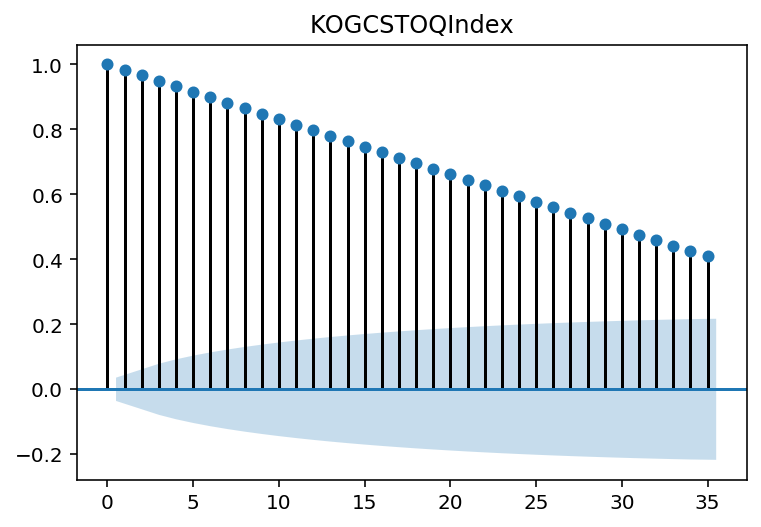

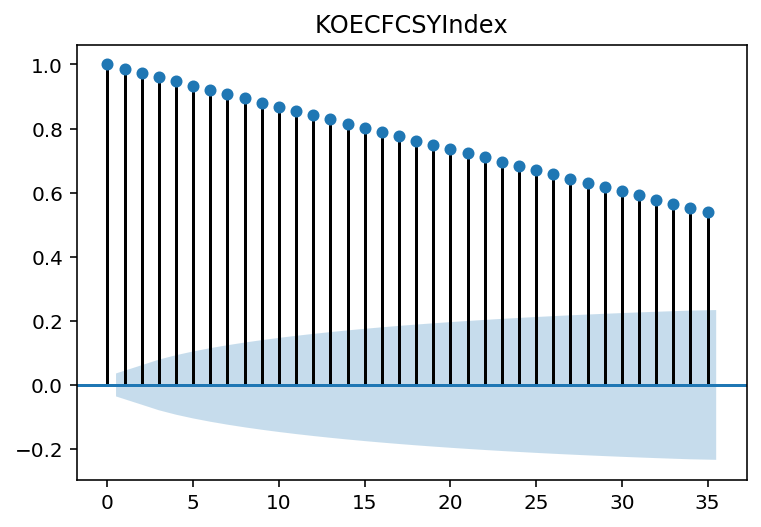

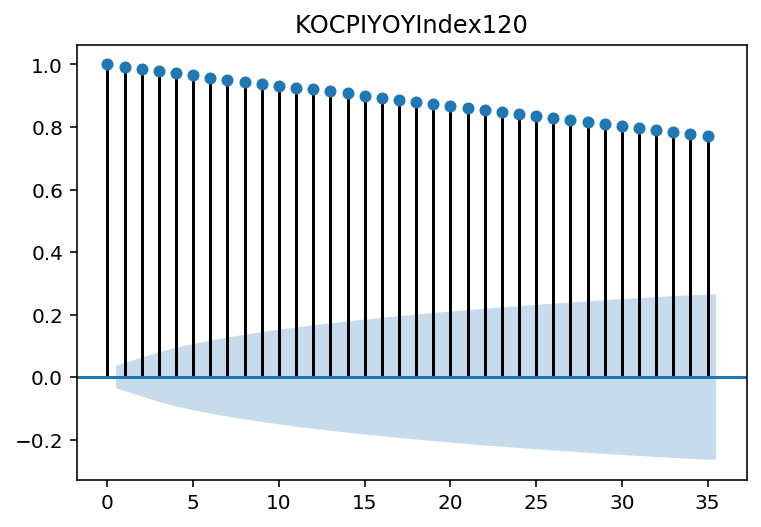

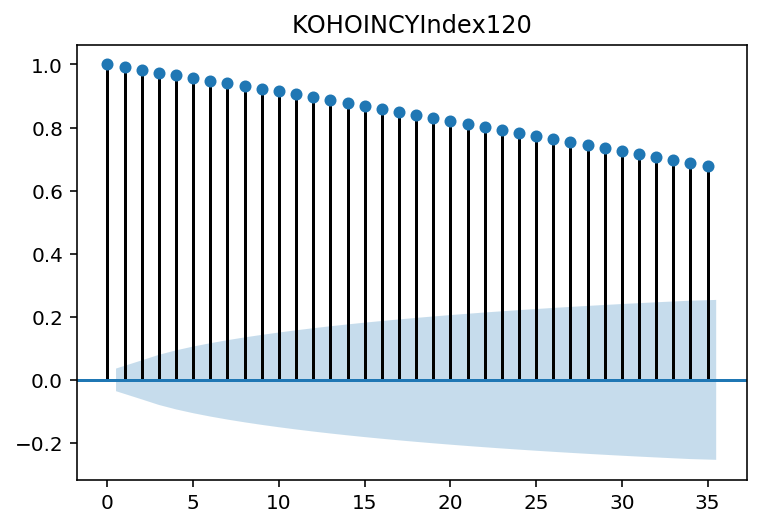

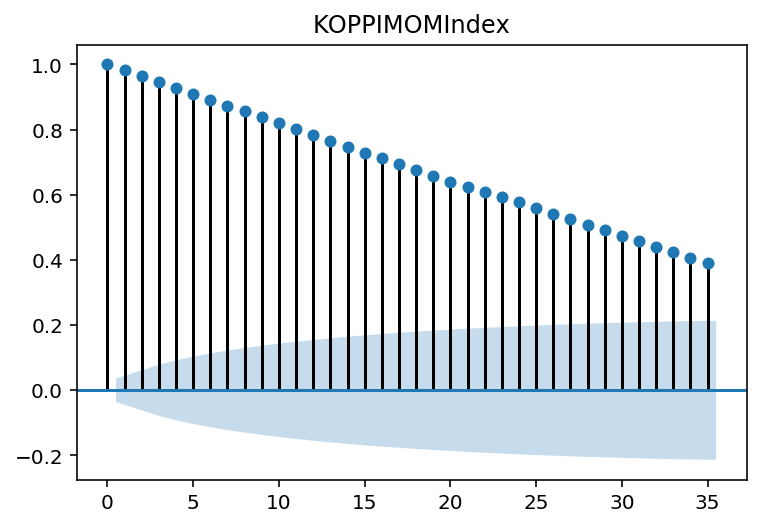

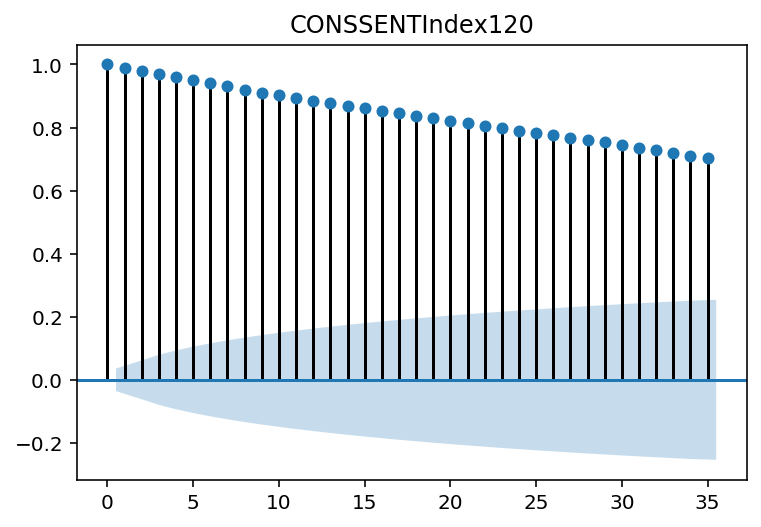

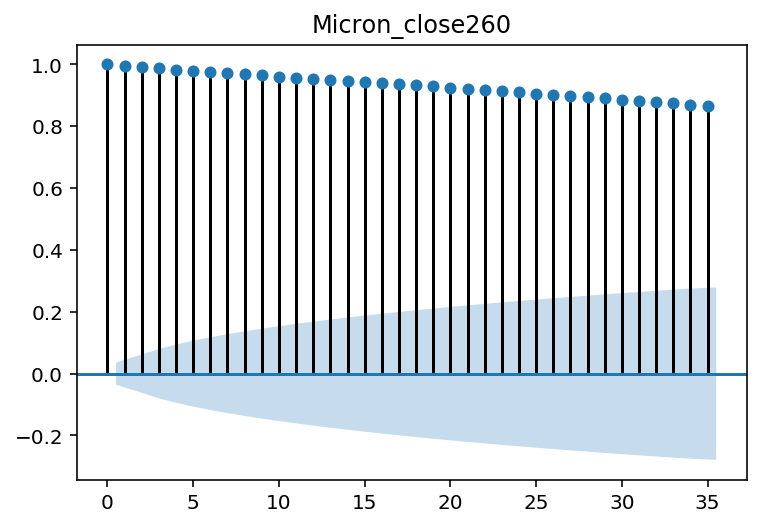

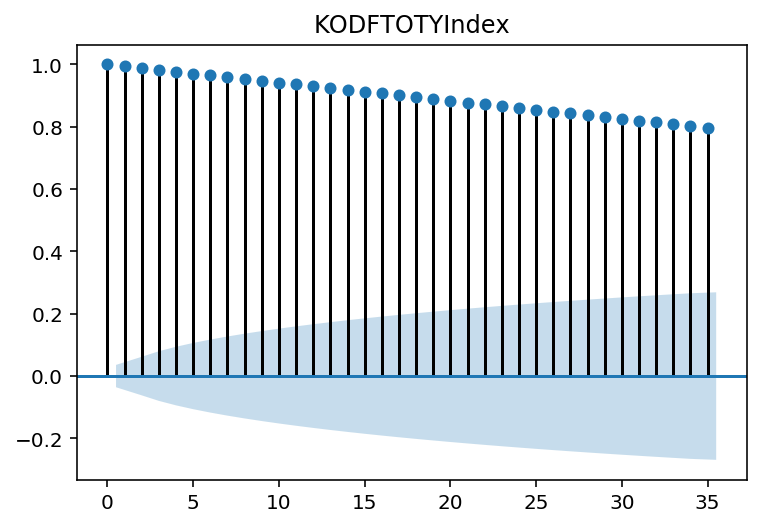

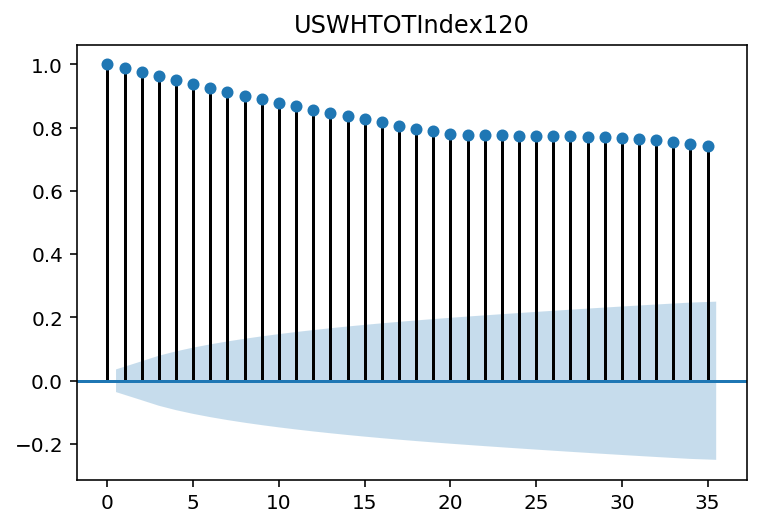

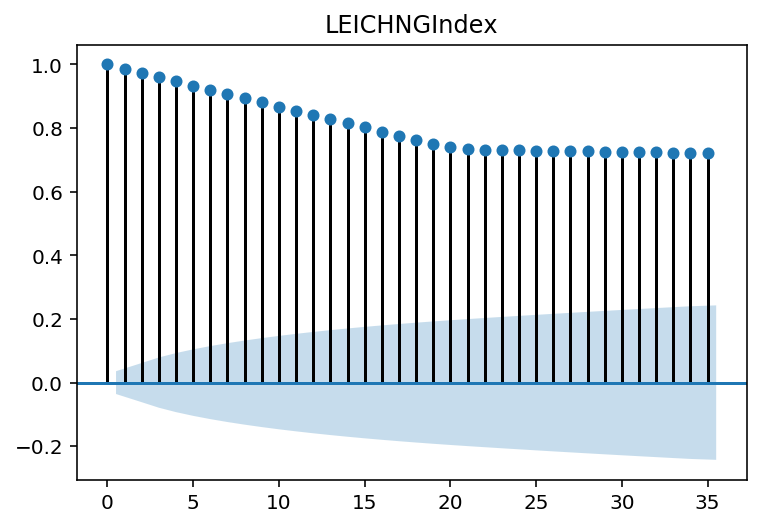

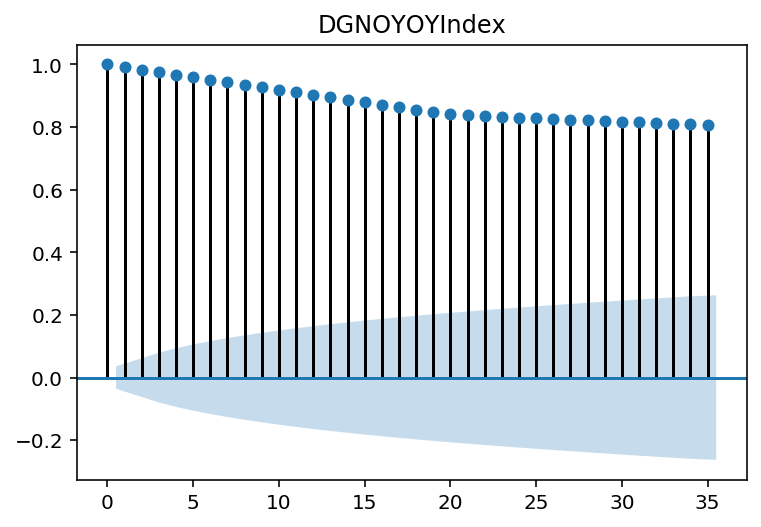

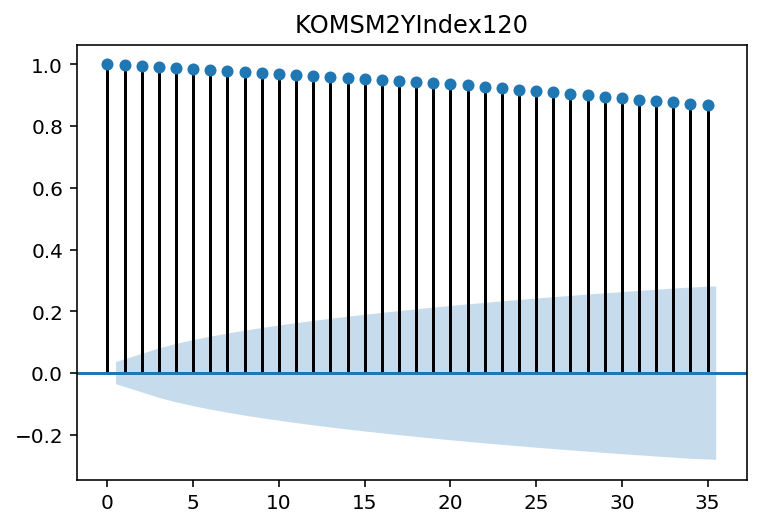

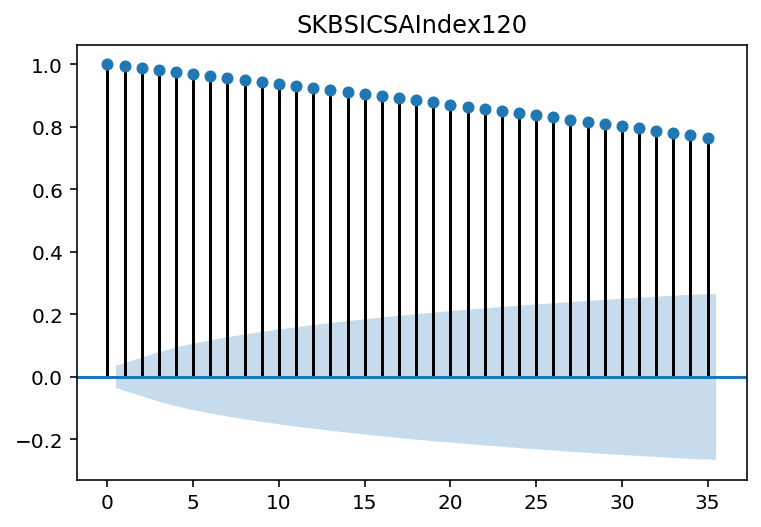

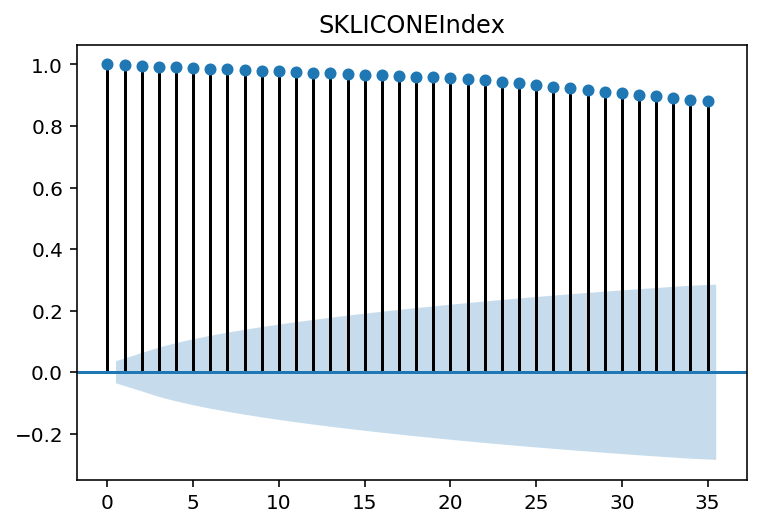

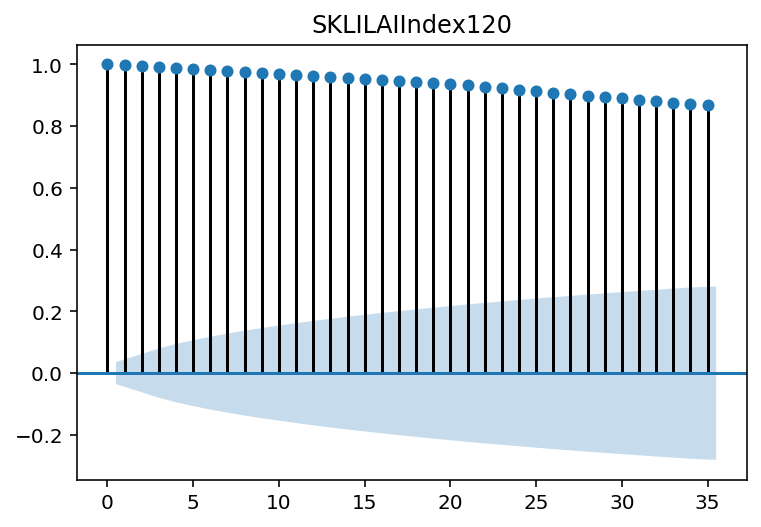

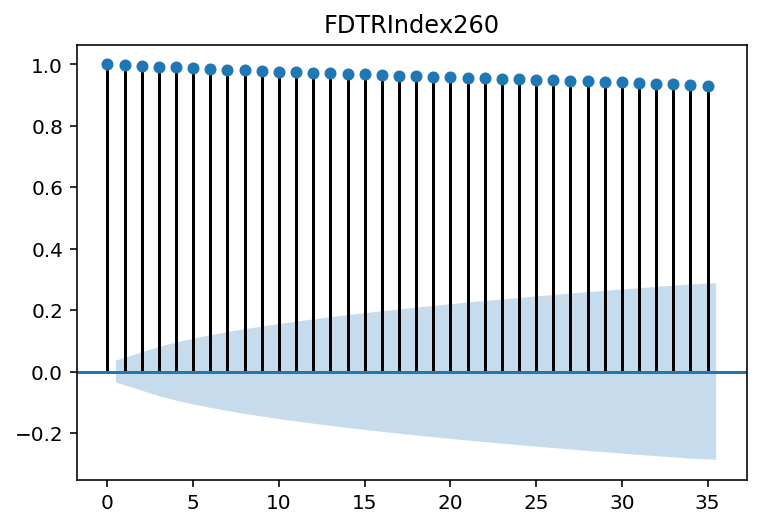

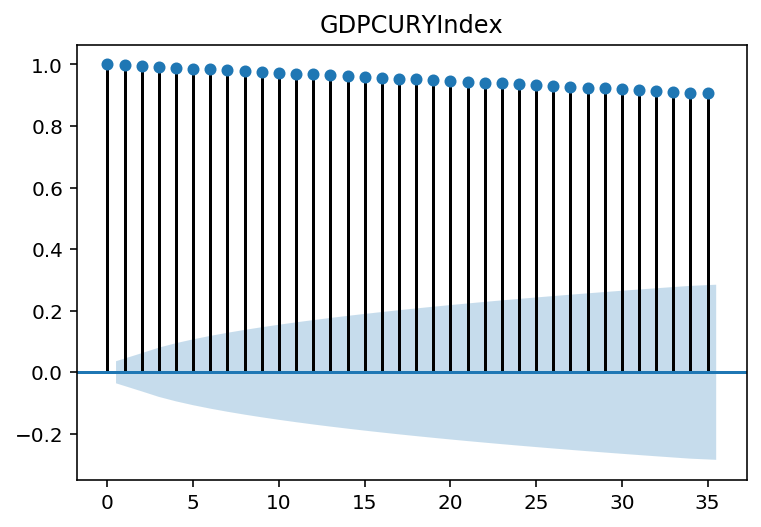

In [34]:
for i in X_data.columns:
    plot_acf(X_data[i])
    plt.title(i)
plt.show()

In [54]:
# scaling 하기전에 columns 뽑기 
col_name = X_data.columns

In [55]:
# scaling과 동시에 변환
X_data = StandardScaler().fit_transform(X_data)

In [56]:
# scaling하면 colname사라지므로 다시 생성
X_data = pd.DataFrame(X_data, columns = col_name)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size = 0.2, shuffle = False)

In [59]:
X_data.shape

(2981, 777)

In [60]:
#X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size = 0.2, shuffle = False)

In [61]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

# Linear Model

In [62]:
# linear model select
ridge_reg = Ridge()
lr_reg = LinearRegression()
#lasso = Lasso(alpha = 100)

In [63]:
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)

In [64]:
metr = CustomMetric(ridge_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.604677,0.1199,0.2156,0.2657,0.705193,0.853333


In [15]:
lr_reg.fit(X_train, y_train)
y_pred = lr_reg.predict(X_test)

In [16]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,-0.547318,-52334023286835845791744.0000,53412082578.0950,64794886473.0677,0.38861,0.446667


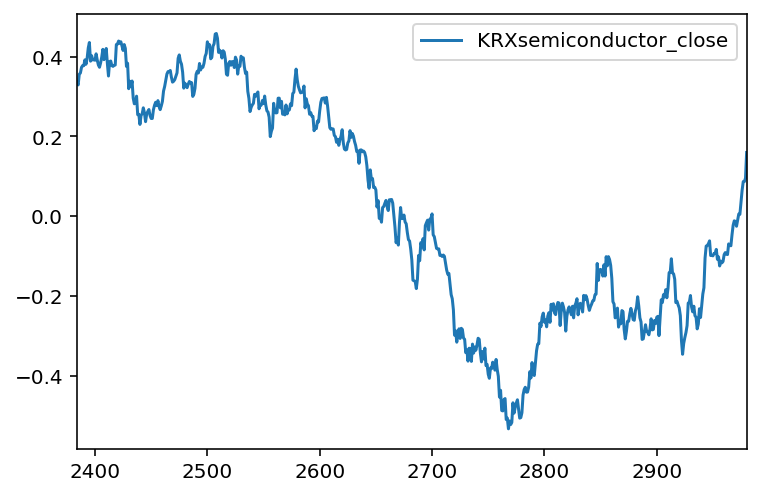

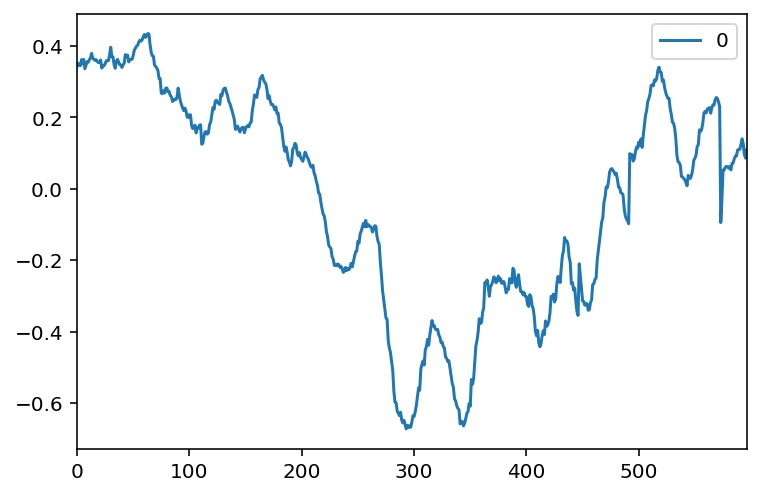

In [66]:
pd.DataFrame(y_test).plot()
pd.DataFrame(ridge_pred).plot()
plt.show()

In [74]:
a = coef_imp.sort_values(by = 'Value', ascending = False)[0:50]

In [83]:
a.iloc[:, 1].values

array(['GDPPIQQIndex', 'PRODNFR%Index', 'GDPCPCECIndex', 'g32',
       'KOCGCGYIndex', 'KOBPFINIndex', 'SPXIndex260', 'SKCIYOYIndex260',
       'SKCIYOYIndex120', 'Intel_close260', 'USMMMNCHIndex',
       'KOEXTOTIndex260', 'KOEXTOTIndex120', 'FDIUSGYOIndex',
       'JPY_KRW_close', 'PIDSDPSIndex', 'KWCDCCurncy', 'MXEF0MTIndex120',
       'LMNIDS03Comdty260', 'Siltronic_close120', 'KOULMGFIndex120',
       'KOULMGFIndex260', 'LEIWKIJIndex260', 'LEIWKIJIndex120',
       'LEIIRTEIndex', 'RCHSINDXIndex', 'KOPSIYIndex', 'DGNOYOYIndex',
       'KOIMPTIYIndex', 'CINDIndex260', 'KOIMTOTYIndex', 'KOVMDOMSIndex',
       'KOECGVTYIndex260', 'KOECGVTYIndex120', 'g64', 'CPMINEXOIndex120',
       'CPMINEXOIndex260', 'NAPMPRICIndex120', 'NAPMPRICIndex260',
       'LEICHNGIndex', 'CPMINORDIndex260', 'CPMINORDIndex120',
       'RSTAYOYIndex', 'KODSDISCIndex', 'KOIPMSIndex260',
       'KOIPMSIndex120', 'USHEYOYIndex260', 'USHEYOYIndex120',
       'KOECGVTYIndex', 'CPICHNGIndex'], dtype=object)

In [78]:
a.loc[:, 1].values

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [1] of <class 'int'>

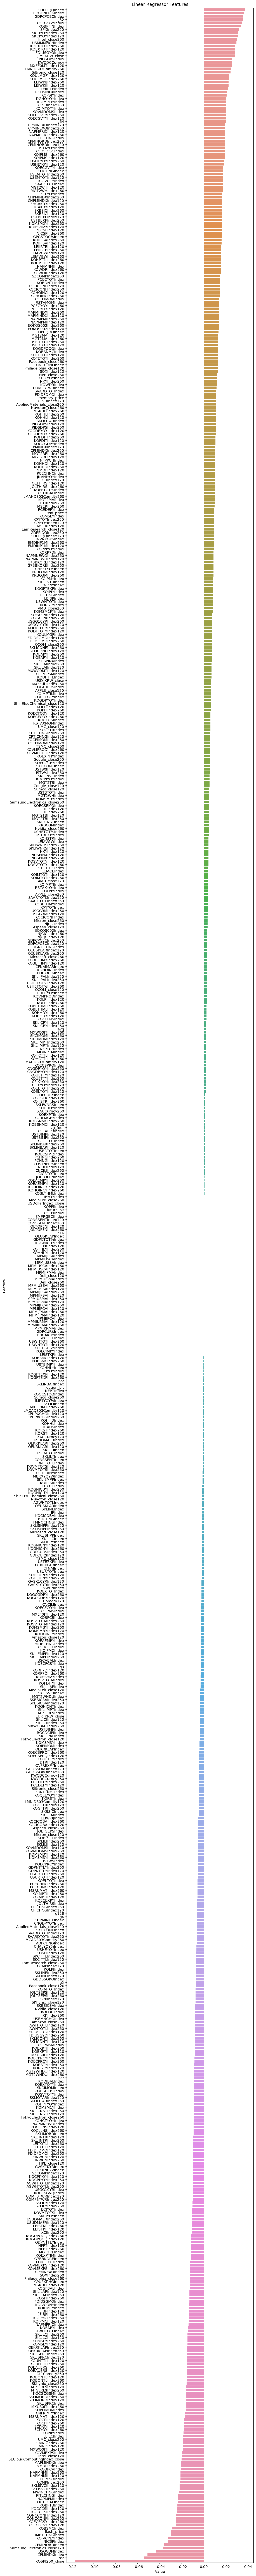

In [71]:
coef_imp = pd.DataFrame(sorted(zip(ridge_reg.coef_, X_train.columns)), columns = ['Value', 'Feature'])
coef_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (10, 100))
sns.barplot(x = 'Value', y = 'Feature', data = coef_imp.sort_values(by = 'Value', ascending = False))
plt.title('Linear Regressor Features')
plt.tight_layout()
plt.show()

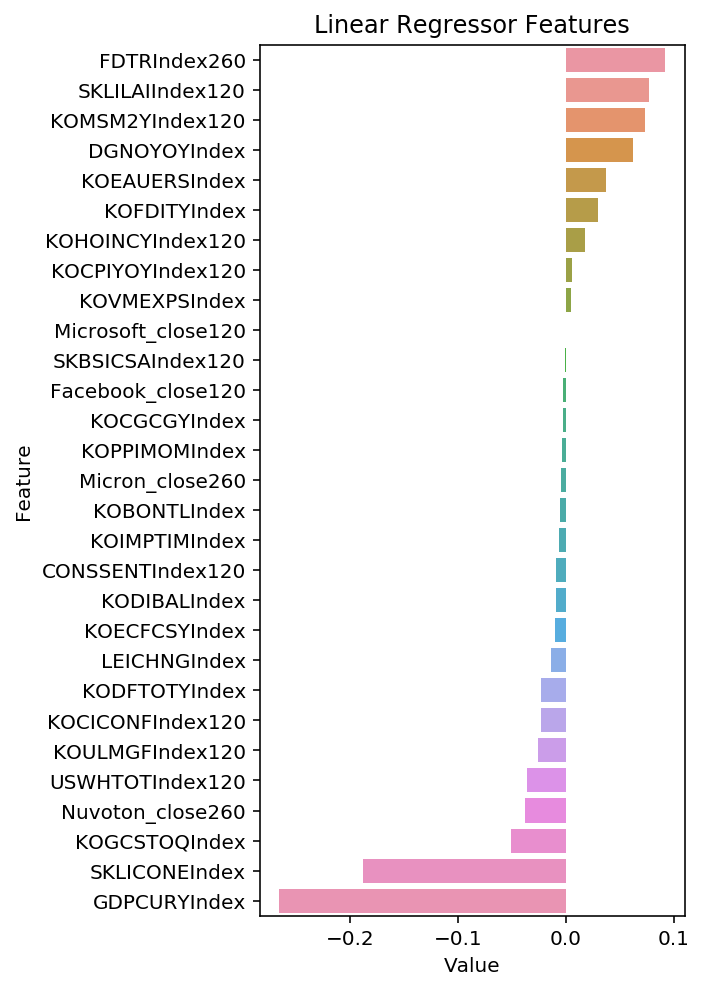

In [22]:
coef_imp = pd.DataFrame(sorted(zip(lr_reg.coef_, X_train.columns)), columns = ['Value', 'Feature'])
coef_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (5, 7))
sns.barplot(x = 'Value', y = 'Feature', data = coef_imp.sort_values(by = 'Value', ascending = False))
plt.title('Linear Regressor Features')
plt.tight_layout()
plt.show()

Tree Model은 feature importance가 따로 뽑히므로 아래와 같이 시각화

# Optuna AutoML을 통한 LightGBM Hyperparameter tuning

In [23]:
import sklearn.ensemble
import sklearn.model_selection
from sklearn.metrics import r2_score
import optuna
import optuna.integration.lightgbm as lgb

In [24]:
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'l2',
    'verbosity': -1,
    'boosting_type': 'gbdt',
}

best_params, tuning_history = dict(), list()

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dval],
                  best_params=best_params,
                  tuning_history=tuning_history,
                  verbose_eval=100,
                  early_stopping_rounds=100,
                  )

prediction = np.rint(model.predict(X_test, num_iteration=model.best_iteration))
r2_score = r2_score(y_test, prediction)

print('Number of finished trials: {}'.format(len(tuning_history)))
print('Best params:', best_params)
print('  r2_score = {}'.format(r2_score))
print('  Params: ')
for key, value in best_params.items():
    print('    {}: {}'.format(key, value))

tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000226372	valid_1's l2: 0.0474127
[200]	training's l2: 0.000112263	valid_1's l2: 0.0469509
[300]	training's l2: 6.83907e-05	valid_1's l2: 0.0468878
[400]	training's l2: 4.54975e-05	valid_1's l2: 0.0467712
Early stopping, best iteration is:
[385]	training's l2: 4.82507e-05	valid_1's l2: 0.0467416


tune_feature_fraction, val_score: 0.046742:  14%|#4        | 1/7 [00:01<00:07,  1.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000220193	valid_1's l2: 0.0521733
Early stopping, best iteration is:
[55]	training's l2: 0.000385493	valid_1's l2: 0.0519551


tune_feature_fraction, val_score: 0.046742:  29%|##8       | 2/7 [00:01<00:04,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000217658	valid_1's l2: 0.0517497
Early stopping, best iteration is:
[92]	training's l2: 0.000235637	valid_1's l2: 0.0516802


tune_feature_fraction, val_score: 0.046742:  43%|####2     | 3/7 [00:02<00:03,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000214137	valid_1's l2: 0.0435003
[200]	training's l2: 0.000105095	valid_1's l2: 0.0430713
[300]	training's l2: 6.38676e-05	valid_1's l2: 0.0431283
Early stopping, best iteration is:
[274]	training's l2: 7.21293e-05	valid_1's l2: 0.0430318


tune_feature_fraction, val_score: 0.043032:  57%|#####7    | 4/7 [00:02<00:02,  1.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000210753	valid_1's l2: 0.0520523
Early stopping, best iteration is:
[13]	training's l2: 0.00587056	valid_1's l2: 0.0512423


tune_feature_fraction, val_score: 0.043032:  71%|#######1  | 5/7 [00:03<00:01,  1.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000216012	valid_1's l2: 0.0568144
Early stopping, best iteration is:
[17]	training's l2: 0.00309027	valid_1's l2: 0.0555502


tune_feature_fraction, val_score: 0.043032:  86%|########5 | 6/7 [00:03<00:00,  1.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000212307	valid_1's l2: 0.0600619
Early stopping, best iteration is:
[13]	training's l2: 0.00587893	valid_1's l2: 0.0561587


tune_num_leaves, val_score: 0.043032:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.73228e-05	valid_1's l2: 0.0552526
Early stopping, best iteration is:
[40]	training's l2: 0.000288517	valid_1's l2: 0.0549578


tune_num_leaves, val_score: 0.043032:   5%|5         | 1/20 [00:01<00:24,  1.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00235172	valid_1's l2: 0.0317852
Early stopping, best iteration is:
[46]	training's l2: 0.00462583	valid_1's l2: 0.0301653


tune_num_leaves, val_score: 0.030165:  10%|#         | 2/20 [00:01<00:17,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.73228e-05	valid_1's l2: 0.0552526
Early stopping, best iteration is:
[40]	training's l2: 0.000288517	valid_1's l2: 0.0549578


tune_num_leaves, val_score: 0.030165:  15%|#5        | 3/20 [00:02<00:16,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.73228e-05	valid_1's l2: 0.0552526
Early stopping, best iteration is:
[40]	training's l2: 0.000288517	valid_1's l2: 0.0549578


tune_num_leaves, val_score: 0.030165:  20%|##        | 4/20 [00:03<00:16,  1.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.73228e-05	valid_1's l2: 0.0552526
Early stopping, best iteration is:
[40]	training's l2: 0.000288517	valid_1's l2: 0.0549578


tune_num_leaves, val_score: 0.030165:  25%|##5       | 5/20 [00:04<00:16,  1.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000188847	valid_1's l2: 0.0474676
[200]	training's l2: 8.91695e-05	valid_1's l2: 0.0471614
[300]	training's l2: 5.30286e-05	valid_1's l2: 0.0469603
[400]	training's l2: 3.44053e-05	valid_1's l2: 0.0469159
[500]	training's l2: 2.32757e-05	valid_1's l2: 0.0468149
[600]	training's l2: 1.63746e-05	valid_1's l2: 0.0467777
[700]	training's l2: 1.17697e-05	valid_1's l2: 0.0466958
[800]	training's l2: 8.62338e-06	valid_1's l2: 0.0466366
[900]	training's l2: 6.33018e-06	valid_1's l2: 0.0466161
Early stopping, best iteration is:
[869]	training's l2: 6.94105e-06	valid_1's l2: 0.0466003


tune_num_leaves, val_score: 0.030165:  30%|###       | 6/20 [00:07<00:21,  1.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000172024	valid_1's l2: 0.0451698
[200]	training's l2: 7.88306e-05	valid_1's l2: 0.0449845
[300]	training's l2: 4.52271e-05	valid_1's l2: 0.0449517
[400]	training's l2: 2.80736e-05	valid_1's l2: 0.0447349
[500]	training's l2: 1.82767e-05	valid_1's l2: 0.0445673
[600]	training's l2: 1.24502e-05	valid_1's l2: 0.0444599
[700]	training's l2: 8.74221e-06	valid_1's l2: 0.0443693
[800]	training's l2: 6.20796e-06	valid_1's l2: 0.0443452
[900]	training's l2: 4.5184e-06	valid_1's l2: 0.0443155
[1000]	training's l2: 3.32514e-06	valid_1's l2: 0.0442863
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 3.32514e-06	valid_1's l2: 0.0442863


tune_num_leaves, val_score: 0.030165:  35%|###5      | 7/20 [00:11<00:30,  2.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.83788e-05	valid_1's l2: 0.0545462
[200]	training's l2: 2.8593e-05	valid_1's l2: 0.0544997
Early stopping, best iteration is:
[106]	training's l2: 8.16004e-05	valid_1's l2: 0.0543797


tune_num_leaves, val_score: 0.030165:  40%|####      | 8/20 [00:12<00:24,  2.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.73228e-05	valid_1's l2: 0.0552526
Early stopping, best iteration is:
[40]	training's l2: 0.000288517	valid_1's l2: 0.0549578


tune_num_leaves, val_score: 0.030165:  45%|####5     | 9/20 [00:14<00:19,  1.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.73228e-05	valid_1's l2: 0.0552526
Early stopping, best iteration is:
[40]	training's l2: 0.000288517	valid_1's l2: 0.0549578


tune_num_leaves, val_score: 0.030165:  50%|#####     | 10/20 [00:15<00:15,  1.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.73228e-05	valid_1's l2: 0.0552526
Early stopping, best iteration is:
[40]	training's l2: 0.000288517	valid_1's l2: 0.0549578


tune_num_leaves, val_score: 0.030165:  55%|#####5    | 11/20 [00:16<00:13,  1.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00235172	valid_1's l2: 0.0317852
Early stopping, best iteration is:
[46]	training's l2: 0.00462583	valid_1's l2: 0.0301653


tune_num_leaves, val_score: 0.030165:  60%|######    | 12/20 [00:16<00:09,  1.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00169004	valid_1's l2: 0.0269011
Early stopping, best iteration is:
[52]	training's l2: 0.00297688	valid_1's l2: 0.0260588


tune_num_leaves, val_score: 0.026059:  65%|######5   | 13/20 [00:17<00:06,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000760282	valid_1's l2: 0.0372952
Early stopping, best iteration is:
[63]	training's l2: 0.00111105	valid_1's l2: 0.036591


tune_num_leaves, val_score: 0.026059:  70%|#######   | 14/20 [00:17<00:04,  1.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000115679	valid_1's l2: 0.0534139
Early stopping, best iteration is:
[24]	training's l2: 0.000991155	valid_1's l2: 0.053097


tune_num_leaves, val_score: 0.026059:  75%|#######5  | 15/20 [00:18<00:03,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.73228e-05	valid_1's l2: 0.0552526
Early stopping, best iteration is:
[40]	training's l2: 0.000288517	valid_1's l2: 0.0549578


tune_num_leaves, val_score: 0.026059:  80%|########  | 16/20 [00:18<00:02,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00235172	valid_1's l2: 0.0317852
Early stopping, best iteration is:
[46]	training's l2: 0.00462583	valid_1's l2: 0.0301653


tune_num_leaves, val_score: 0.026059:  85%|########5 | 17/20 [00:19<00:01,  1.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000108063	valid_1's l2: 0.0572567
Early stopping, best iteration is:
[23]	training's l2: 0.00109723	valid_1's l2: 0.0566442


tune_num_leaves, val_score: 0.026059:  90%|######### | 18/20 [00:19<00:01,  1.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000225411	valid_1's l2: 0.0457463
Early stopping, best iteration is:
[56]	training's l2: 0.000381936	valid_1's l2: 0.0454768


tune_num_leaves, val_score: 0.026059:  95%|#########5| 19/20 [00:19<00:00,  2.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.73228e-05	valid_1's l2: 0.0552526
Early stopping, best iteration is:
[40]	training's l2: 0.000288517	valid_1's l2: 0.0549578


tune_num_leaves, val_score: 0.026059: 100%|##########| 20/20 [00:21<00:00,  1.06s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00163084	valid_1's l2: 0.0302473
Early stopping, best iteration is:
[41]	training's l2: 0.00375948	valid_1's l2: 0.0293861


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  10%|#         | 1/10 [00:00<00:00,  9.18it/s][I 2020-03-25 13:49:23,436] Finished trial#0 resulted in value: 0.02938605989116576. Current best value is 0.02938605989116576 with parameters: {'bagging_fraction': 0.42379023235646796, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  10%|#         | 1/10 [00:00<00:00,  9.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00158745	valid_1's l2: 0.0322666
Early stopping, best iteration is:
[43]	training's l2: 0.00349214	valid_1's l2: 0.030127


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  20%|##        | 2/10 [00:00<00:01,  7.46it/s][I 2020-03-25 13:49:23,629] Finished trial#1 resulted in value: 0.030126978899567954. Current best value is 0.02938605989116576 with parameters: {'bagging_fraction': 0.42379023235646796, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  20%|##        | 2/10 [00:00<00:01,  7.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00162004	valid_1's l2: 0.0294411
Early stopping, best iteration is:
[46]	training's l2: 0.00325701	valid_1's l2: 0.0272229


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  30%|###       | 3/10 [00:00<00:01,  6.52it/s][I 2020-03-25 13:49:23,831] Finished trial#2 resulted in value: 0.02722287118795984. Current best value is 0.02722287118795984 with parameters: {'bagging_fraction': 0.9054591000641797, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  30%|###       | 3/10 [00:00<00:01,  6.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00168074	valid_1's l2: 0.0284501
Early stopping, best iteration is:
[33]	training's l2: 0.0047264	valid_1's l2: 0.0265895


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  40%|####      | 4/10 [00:00<00:00,  6.32it/s][I 2020-03-25 13:49:24,000] Finished trial#3 resulted in value: 0.026589530693248282. Current best value is 0.026589530693248282 with parameters: {'bagging_fraction': 0.5713467084469893, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  40%|####      | 4/10 [00:00<00:00,  6.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00161644	valid_1's l2: 0.0314801
Early stopping, best iteration is:
[75]	training's l2: 0.00212533	valid_1's l2: 0.0301875


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  50%|#####     | 5/10 [00:00<00:00,  5.93it/s][I 2020-03-25 13:49:24,199] Finished trial#4 resulted in value: 0.03018747008235224. Current best value is 0.026589530693248282 with parameters: {'bagging_fraction': 0.5713467084469893, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  50%|#####     | 5/10 [00:00<00:00,  5.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00162322	valid_1's l2: 0.0376165
Early stopping, best iteration is:
[34]	training's l2: 0.00452792	valid_1's l2: 0.0353117


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  60%|######    | 6/10 [00:01<00:00,  5.67it/s][I 2020-03-25 13:49:24,388] Finished trial#5 resulted in value: 0.03531174776443586. Current best value is 0.026589530693248282 with parameters: {'bagging_fraction': 0.5713467084469893, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  60%|######    | 6/10 [00:01<00:00,  5.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00157073	valid_1's l2: 0.0294047
Early stopping, best iteration is:
[30]	training's l2: 0.00513069	valid_1's l2: 0.0263489


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  70%|#######   | 7/10 [00:01<00:00,  4.34it/s][I 2020-03-25 13:49:24,743] Finished trial#6 resulted in value: 0.02634886995566829. Current best value is 0.02634886995566829 with parameters: {'bagging_fraction': 0.8142235239642475, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  70%|#######   | 7/10 [00:01<00:00,  4.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00163123	valid_1's l2: 0.0293139
[200]	training's l2: 0.000955483	valid_1's l2: 0.0302526
Early stopping, best iteration is:
[117]	training's l2: 0.00143722	valid_1's l2: 0.0287097


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  80%|########  | 8/10 [00:01<00:00,  4.17it/s][I 2020-03-25 13:49:25,008] Finished trial#7 resulted in value: 0.02870966258180755. Current best value is 0.02634886995566829 with parameters: {'bagging_fraction': 0.8142235239642475, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  80%|########  | 8/10 [00:01<00:00,  4.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00163296	valid_1's l2: 0.029336
Early stopping, best iteration is:
[32]	training's l2: 0.00467578	valid_1's l2: 0.0270469


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  90%|######### | 9/10 [00:01<00:00,  4.62it/s][I 2020-03-25 13:49:25,175] Finished trial#8 resulted in value: 0.027046905486469913. Current best value is 0.02634886995566829 with parameters: {'bagging_fraction': 0.8142235239642475, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059:  90%|######### | 9/10 [00:01<00:00,  4.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00166338	valid_1's l2: 0.0308603
Early stopping, best iteration is:
[26]	training's l2: 0.00606117	valid_1's l2: 0.0282519


tune_bagging_fraction_and_bagging_freq, val_score: 0.026059: 100%|##########| 10/10 [00:02<00:00,  4.94it/s][I 2020-03-25 13:49:25,339] Finished trial#9 resulted in value: 0.028251906376346912. Current best value is 0.02634886995566829 with parameters: {'bagging_fraction': 0.8142235239642475, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.026059: 100%|##########| 10/10 [00:02<00:00,  4.84it/s]
tune_feature_fraction, val_score: 0.026059:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00165978	valid_1's l2: 0.0384528
Early stopping, best iteration is:
[42]	training's l2: 0.00368523	valid_1's l2: 0.0364983


tune_feature_fraction, val_score: 0.026059:  17%|#6        | 1/6 [00:00<00:00,  7.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00160383	valid_1's l2: 0.0346654
Early stopping, best iteration is:
[41]	training's l2: 0.00362364	valid_1's l2: 0.0326787


tune_feature_fraction, val_score: 0.026059:  33%|###3      | 2/6 [00:00<00:00,  8.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00169004	valid_1's l2: 0.0269011
Early stopping, best iteration is:
[52]	training's l2: 0.00297688	valid_1's l2: 0.0260588


tune_feature_fraction, val_score: 0.026059:  50%|#####     | 3/6 [00:00<00:00,  7.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00165696	valid_1's l2: 0.0279934
Early stopping, best iteration is:
[53]	training's l2: 0.00283302	valid_1's l2: 0.0272969


tune_feature_fraction, val_score: 0.026059:  67%|######6   | 4/6 [00:00<00:00,  6.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00155801	valid_1's l2: 0.0277599
Early stopping, best iteration is:
[41]	training's l2: 0.003636	valid_1's l2: 0.0270153


tune_feature_fraction, val_score: 0.026059:  83%|########3 | 5/6 [00:00<00:00,  6.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00161235	valid_1's l2: 0.0282896
Early stopping, best iteration is:
[47]	training's l2: 0.00312556	valid_1's l2: 0.0258621


tune_feature_fraction, val_score: 0.025862: 100%|##########| 6/6 [00:01<00:00,  5.19it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.025862:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00368086	valid_1's l2: 0.0221319
Early stopping, best iteration is:
[85]	training's l2: 0.00368258	valid_1's l2: 0.0221276


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:   0%|          | 0/20 [00:00<?, ?it/s][I 2020-03-25 13:49:26,651] Finished trial#0 resulted in value: 0.02212759864116139. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:   5%|5         | 1/20 [00:00<00:03,  6.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00161235	valid_1's l2: 0.0282896
Early stopping, best iteration is:
[47]	training's l2: 0.00312556	valid_1's l2: 0.0258621


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  10%|#         | 2/20 [00:00<00:02,  6.57it/s][I 2020-03-25 13:49:26,866] Finished trial#1 resulted in value: 0.025862061596514354. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  10%|#         | 2/20 [00:00<00:02,  6.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00179878	valid_1's l2: 0.0273461
Early stopping, best iteration is:
[60]	training's l2: 0.00275822	valid_1's l2: 0.0262726


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  15%|#5        | 3/20 [00:00<00:02,  6.19it/s][I 2020-03-25 13:49:27,048] Finished trial#2 resulted in value: 0.026272594366937504. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  15%|#5        | 3/20 [00:00<00:02,  6.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00166665	valid_1's l2: 0.0284628
Early stopping, best iteration is:
[48]	training's l2: 0.00318979	valid_1's l2: 0.0278136


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  20%|##        | 4/20 [00:00<00:02,  5.95it/s][I 2020-03-25 13:49:27,248] Finished trial#3 resulted in value: 0.02781362779716634. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  20%|##        | 4/20 [00:00<00:02,  5.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00161235	valid_1's l2: 0.0282896
Early stopping, best iteration is:
[47]	training's l2: 0.00312556	valid_1's l2: 0.0258621


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  25%|##5       | 5/20 [00:00<00:02,  5.65it/s][I 2020-03-25 13:49:27,428] Finished trial#4 resulted in value: 0.02586206322003985. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  25%|##5       | 5/20 [00:00<00:02,  5.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00161235	valid_1's l2: 0.0282896
Early stopping, best iteration is:
[47]	training's l2: 0.00312556	valid_1's l2: 0.0258621


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  30%|###       | 6/20 [00:01<00:02,  5.80it/s][I 2020-03-25 13:49:27,600] Finished trial#5 resulted in value: 0.02586206443652072. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  30%|###       | 6/20 [00:01<00:02,  5.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00161079	valid_1's l2: 0.029806
Early stopping, best iteration is:
[34]	training's l2: 0.00448932	valid_1's l2: 0.0275378


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  35%|###5      | 7/20 [00:01<00:02,  5.79it/s][I 2020-03-25 13:49:27,766] Finished trial#6 resulted in value: 0.027537823981304502. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  35%|###5      | 7/20 [00:01<00:02,  5.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00161236	valid_1's l2: 0.0282896
Early stopping, best iteration is:
[47]	training's l2: 0.00312557	valid_1's l2: 0.0258621


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  40%|####      | 8/20 [00:01<00:02,  5.36it/s][I 2020-03-25 13:49:27,986] Finished trial#7 resulted in value: 0.02586206686697895. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  40%|####      | 8/20 [00:01<00:02,  5.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00158535	valid_1's l2: 0.0264022
Early stopping, best iteration is:
[43]	training's l2: 0.00341101	valid_1's l2: 0.0249342


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  45%|####5     | 9/20 [00:01<00:01,  5.59it/s][I 2020-03-25 13:49:28,144] Finished trial#8 resulted in value: 0.024934215173606857. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  45%|####5     | 9/20 [00:01<00:01,  5.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00161235	valid_1's l2: 0.0282896
Early stopping, best iteration is:
[47]	training's l2: 0.00312556	valid_1's l2: 0.0258621


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  50%|#####     | 10/20 [00:01<00:01,  5.91it/s][I 2020-03-25 13:49:28,291] Finished trial#9 resulted in value: 0.025862062270443676. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  50%|#####     | 10/20 [00:01<00:01,  5.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00269918	valid_1's l2: 0.0293212
[200]	training's l2: 0.00260081	valid_1's l2: 0.0292531
Early stopping, best iteration is:
[109]	training's l2: 0.00262836	valid_1's l2: 0.0291867


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  55%|#####5    | 11/20 [00:01<00:01,  6.01it/s][I 2020-03-25 13:49:28,453] Finished trial#10 resulted in value: 0.029186684734424508. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  55%|#####5    | 11/20 [00:01<00:01,  6.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00163108	valid_1's l2: 0.0282954
Early stopping, best iteration is:
[41]	training's l2: 0.00361616	valid_1's l2: 0.0269741


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  60%|######    | 12/20 [00:02<00:01,  6.20it/s][I 2020-03-25 13:49:28,600] Finished trial#11 resulted in value: 0.02697409735966294. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  60%|######    | 12/20 [00:02<00:01,  6.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00153786	valid_1's l2: 0.0265261
Early stopping, best iteration is:
[57]	training's l2: 0.00256879	valid_1's l2: 0.025191


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  65%|######5   | 13/20 [00:02<00:01,  6.33it/s][I 2020-03-25 13:49:28,751] Finished trial#12 resulted in value: 0.02519097933713669. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  65%|######5   | 13/20 [00:02<00:01,  6.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00351227	valid_1's l2: 0.0248169
Early stopping, best iteration is:
[85]	training's l2: 0.00352555	valid_1's l2: 0.0247976


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  70%|#######   | 14/20 [00:02<00:00,  6.51it/s][I 2020-03-25 13:49:28,894] Finished trial#13 resulted in value: 0.024797567963930803. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  70%|#######   | 14/20 [00:02<00:00,  6.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00295854	valid_1's l2: 0.0267723
Early stopping, best iteration is:
[88]	training's l2: 0.00311075	valid_1's l2: 0.026693


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  75%|#######5  | 15/20 [00:02<00:00,  6.66it/s][I 2020-03-25 13:49:29,036] Finished trial#14 resulted in value: 0.026693034163827154. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  75%|#######5  | 15/20 [00:02<00:00,  6.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00158659	valid_1's l2: 0.0274125
Early stopping, best iteration is:
[47]	training's l2: 0.00312651	valid_1's l2: 0.0258598


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  80%|########  | 16/20 [00:02<00:00,  6.95it/s][I 2020-03-25 13:49:29,165] Finished trial#15 resulted in value: 0.0258598470005736. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  80%|########  | 16/20 [00:02<00:00,  6.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00158648	valid_1's l2: 0.0274155
Early stopping, best iteration is:
[47]	training's l2: 0.00312608	valid_1's l2: 0.0258622


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  85%|########5 | 17/20 [00:02<00:00,  7.09it/s][I 2020-03-25 13:49:29,301] Finished trial#16 resulted in value: 0.02586219305635733. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  85%|########5 | 17/20 [00:02<00:00,  7.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00161235	valid_1's l2: 0.0282896
Early stopping, best iteration is:
[47]	training's l2: 0.00312556	valid_1's l2: 0.0258621


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  90%|######### | 18/20 [00:02<00:00,  7.32it/s][I 2020-03-25 13:49:29,425] Finished trial#17 resulted in value: 0.025862061355936022. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  90%|######### | 18/20 [00:02<00:00,  7.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00173536	valid_1's l2: 0.0326753
Early stopping, best iteration is:
[52]	training's l2: 0.00306099	valid_1's l2: 0.0315428


tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  95%|#########5| 19/20 [00:03<00:00,  7.27it/s][I 2020-03-25 13:49:29,566] Finished trial#18 resulted in value: 0.03154276408913181. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128:  95%|#########5| 19/20 [00:03<00:00,  7.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00180128	valid_1's l2: 0.0319525
Early stopping, best iteration is:
[33]	training's l2: 0.00482659	valid_1's l2: 0.0309195


tune_lambda_l1_and_lambda_l2, val_score: 0.022128: 100%|##########| 20/20 [00:03<00:00,  7.36it/s][I 2020-03-25 13:49:29,704] Finished trial#19 resulted in value: 0.030919518895735253. Current best value is 0.02212759864116139 with parameters: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656}.
tune_lambda_l1_and_lambda_l2, val_score: 0.022128: 100%|##########| 20/20 [00:03<00:00,  6.25it/s]
tune_min_child_samples, val_score: 0.022128:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00375125	valid_1's l2: 0.0227986
Early stopping, best iteration is:
[71]	training's l2: 0.00396303	valid_1's l2: 0.0226154


tune_min_child_samples, val_score: 0.022128:  20%|##        | 1/5 [00:00<00:00,  8.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00375125	valid_1's l2: 0.0227986
Early stopping, best iteration is:
[71]	training's l2: 0.00396303	valid_1's l2: 0.0226154


tune_min_child_samples, val_score: 0.022128:  40%|####      | 2/5 [00:00<00:00,  8.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00368048	valid_1's l2: 0.0221312
Early stopping, best iteration is:
[85]	training's l2: 0.00368258	valid_1's l2: 0.0221276


tune_min_child_samples, val_score: 0.022128:  60%|######    | 3/5 [00:00<00:00,  8.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00381374	valid_1's l2: 0.0240249
Early stopping, best iteration is:
[60]	training's l2: 0.00444257	valid_1's l2: 0.023596


tune_min_child_samples, val_score: 0.022128:  80%|########  | 4/5 [00:00<00:00,  8.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0037371	valid_1's l2: 0.0233825
Early stopping, best iteration is:
[85]	training's l2: 0.0037371	valid_1's l2: 0.0233825


tune_min_child_samples, val_score: 0.022128: 100%|##########| 5/5 [00:00<00:00,  7.91it/s]


Number of finished trials: 68
Best params: {'lambda_l1': 9.135439116115348, 'lambda_l2': 0.0034544071063669656, 'num_leaves': 5, 'feature_fraction': 0.7799999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  r2_score = -0.005747686438836608
  Params: 
    lambda_l1: 9.135439116115348
    lambda_l2: 0.0034544071063669656
    num_leaves: 5
    feature_fraction: 0.7799999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


### Tuning된 값 입력하여 모델 선언

In [19]:
lgb_reg = LGBMRegressor()

In [19]:
lgb_reg = LGBMRegressor(lambda_l1 = 9.135439116115348, lambda_l2 = 0.0034544071063669656, num_leaves = 5, feature_fraction = 0.7799999999999999, bagging_fraction = 1.0, bagging_freq = 0, min_child_samples = 20)

In [20]:
lgb_reg.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=1.0, bagging_freq=0, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7799999999999999, importance_type='split',
              lambda_l1=9.135439116115348, lambda_l2=0.0034544071063669656,
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=5, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [21]:
lgb_pred = lgb_reg.predict(X_test)

In [22]:
y_test = np.array(y_test)

In [23]:
metr = CustomMetric(lgb_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.76023,0.4867,0.1822,0.2029,0.871022,0.946667


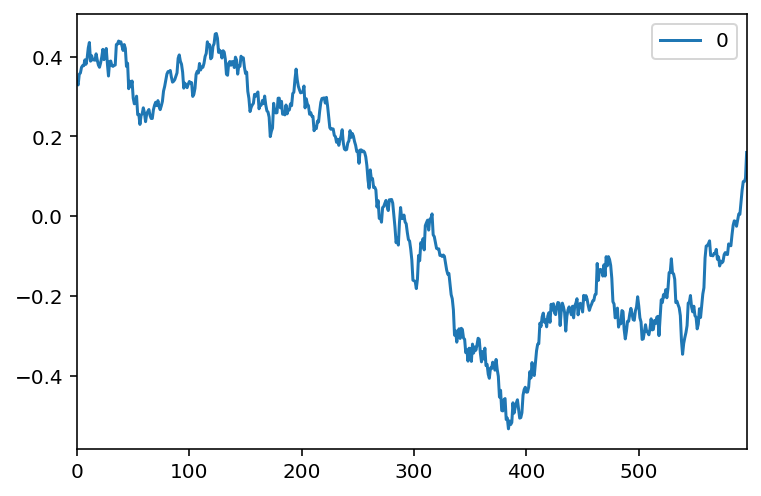

In [25]:
pd.DataFrame(y_test).plot()

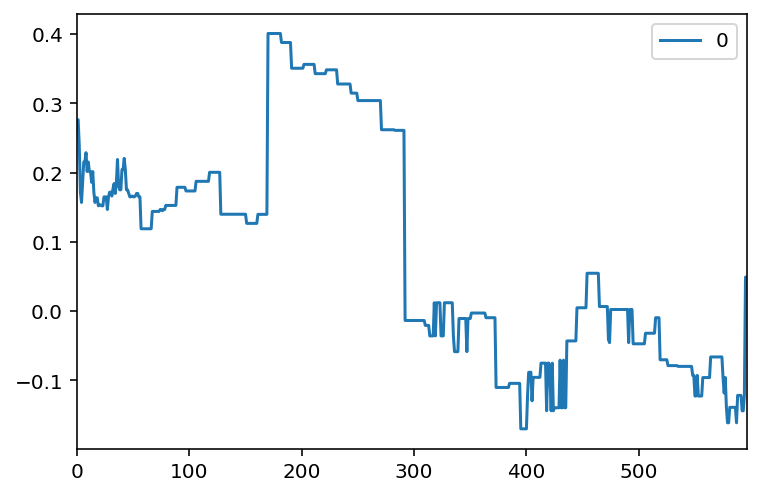

In [24]:
pd.DataFrame(lgb_pred).plot()

In [23]:
pd.DataFrame(y_pred).plot()

NameError: name 'y_pred' is not defined

In [19]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

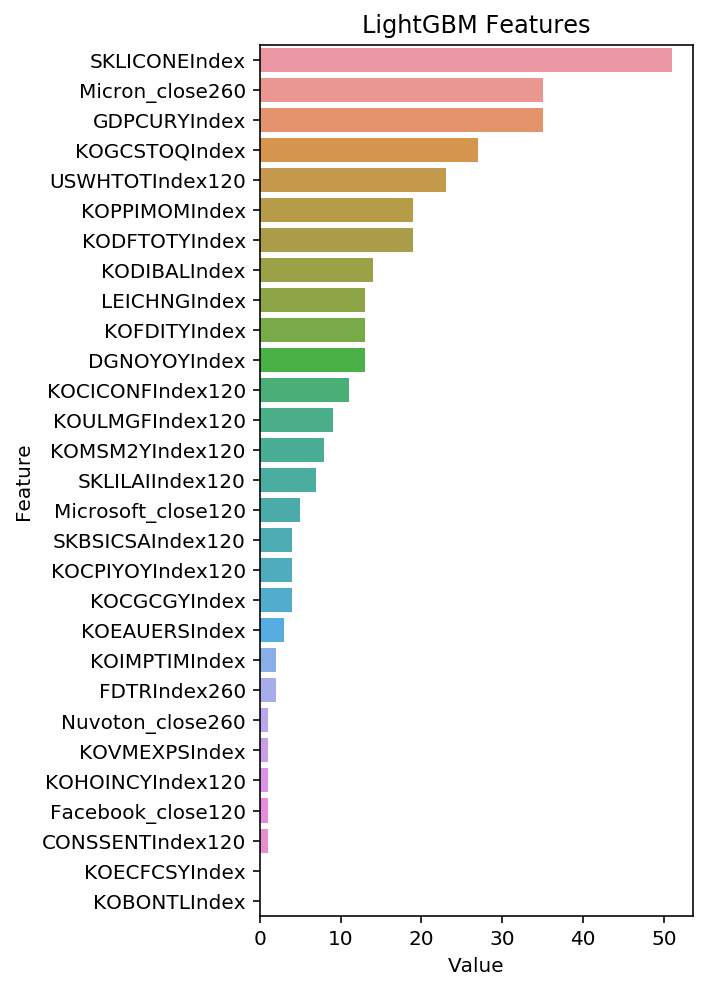

In [26]:
feat_imp = pd.DataFrame(sorted(zip(lgb_reg.feature_importances_, X_train.columns)), columns = ['Value', 'Feature'])
feat_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (5, 7))
sns.barplot(x = 'Value', y = 'Feature', data = feat_imp.sort_values(by = 'Value', ascending = False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('lgbm_importances_1.png')
plt.show()